In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')

#from wordcloud import WordCloud
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 900)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Ensemble-Sentiment Analysis/tweets data/twitter_training.csv',header=None)
validation = pd.read_csv('/content/drive/MyDrive/Ensemble-Sentiment Analysis/tweets data/twitter_validation.csv',header=None)

train.columns=['Tweet ID','Entity','Sentiment','Tweet Content']
validation.columns=['Tweet ID','Entity','Sentiment','Tweet Content']

print("Training DataSet: \n")
train = train.sample(5000)
display(train.head())

Training DataSet: 



,Tweet ID,Entity,Sentiment,Tweet Content
43701,10302,PlayerUnknownsBattlegrounds(PUBG),Negative,When you ban PUBG Mobile but suddenly realize you have to attract 50 million people pic.google.com / c5xpXwbM3F
69293,3870,Cyberpunk2077,Positive,This game is completely fucking wild.
40735,1390,Battlefield,Negative,Ross rifle is INSANE . . Full vid: youtu.be/gLxg_jG5SaE https://t.co/yQFjbZA5aC
65457,6809,johnson&johnson,Irrelevant,Watch for different colors to be more expensive
37517,5232,Hearthstone,Negative,Does... anyone have problem with Hearthstone of logging on their Asia server or atm? I can't find anywhere about maintenance assistance or something similar.


In [ ]:
print("Validation DataSet: \n")
display(validation.head())

Validation DataSet: 



,Tweet ID,Entity,Sentiment,Tweet Content
0,S.no,Company,Sentiment,Text
1,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma..."
2,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug dealer' bbc.co.uk/news/av/busine…
3,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it functions so poorly on my @SamsungUS Chromebook? 🙄
4,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking, it's a truly awful game."


In [ ]:
train = train.dropna(subset=['Tweet Content'])

display(train.isnull().sum())
print()
display(validation.isnull().sum())

,0
Tweet ID,0
Entity,0
Sentiment,0
Tweet Content,0


,0
Tweet ID,0
Entity,0
Sentiment,0
Tweet Content,0


In [ ]:
duplicates = train[train.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
train = train.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

duplicates = validation[validation.duplicated(subset=['Entity', 'Sentiment', 'Tweet Content'], keep=False)]
validation = validation.drop_duplicates(subset=['Entity', 'Sentiment', 'Tweet Content'], keep='first')

In [ ]:
import pandas as pd

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts for train and validation data
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Combine counts into a single DataFrame
combined_counts = pd.concat([sentiment_counts_train, sentiment_counts_validation], axis=1)

# Fill missing values (if any) with 0
combined_counts.fillna(0, inplace=True)

# Rename columns
combined_counts.columns = ['Test Data', 'Validation Data']  # Set desired column names

combined_counts

,Test Data,Validation Data
Sentiment,,
Negative,1520.0,266
Positive,1389.0,277
Neutral,1199.0,285
Irrelevant,833.0,172
Sentiment,0.0,1


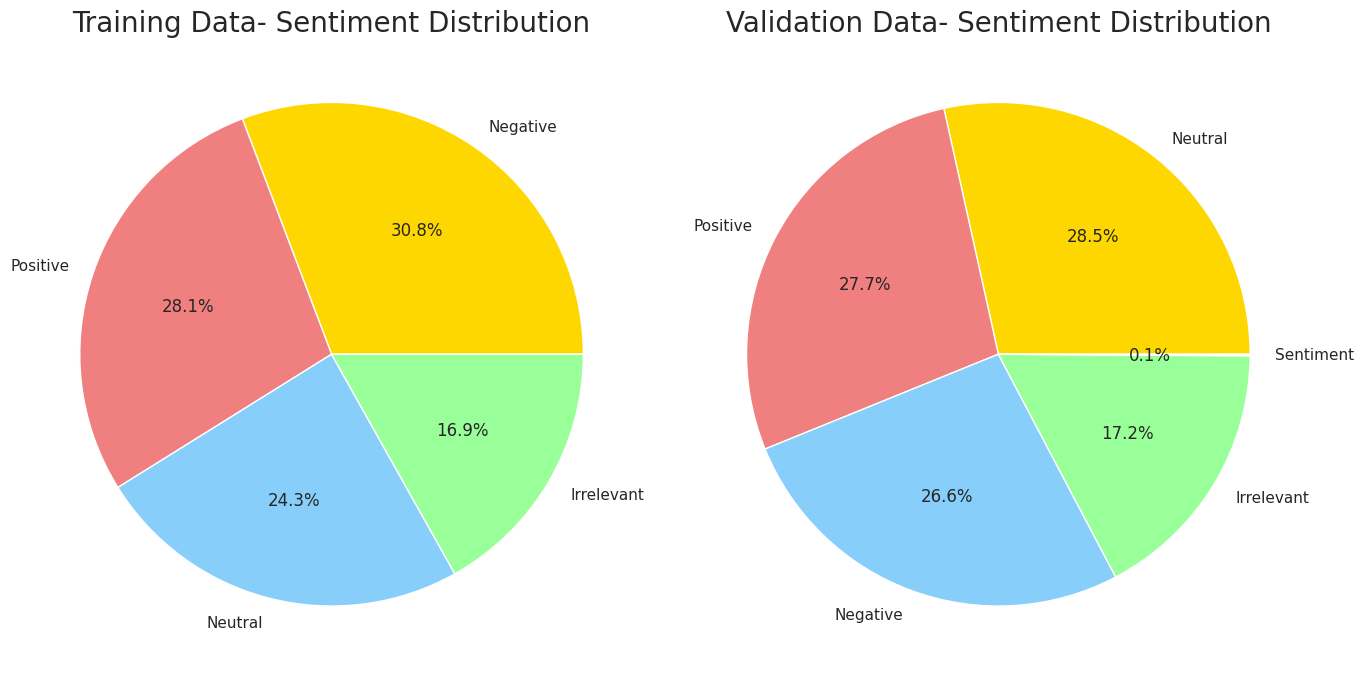

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'train' and 'validation' are your DataFrames

# Calculate sentiment counts
sentiment_counts_train = train['Sentiment'].value_counts()
sentiment_counts_validation = validation['Sentiment'].value_counts()

# Create subplots for side-by-side comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))  # Adjust figsize for better view

# Create pie chart for training data
ax1.pie(sentiment_counts_train, labels=sentiment_counts_train.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax1.set_title('Training Data- Sentiment Distribution', fontsize=20)

# Create pie chart for validation data
ax2.pie(sentiment_counts_validation, labels=sentiment_counts_validation.index, autopct='%1.1f%%', colors=['gold', 'lightcoral', 'lightskyblue','#99FF99'])
ax2.set_title('Validation Data- Sentiment Distribution', fontsize=20)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the value counts of 'Entity'
entity_counts = train['Entity'].value_counts()

# Get the top 9 names
top_names = entity_counts.head(19)

# Aggregate the tenth name as 'Other'
other_count = entity_counts[19:].sum()
top_names['Other'] = other_count

# Display the top 19 names and 'Other'
top_names.to_frame()

,count
Entity,
Overwatch,173
TomClancysRainbowSix,170
MaddenNFL,169
Amazon,167
Microsoft,167
Battlefield,165
HomeDepot,165
WorldOfCraft,165
AssassinsCreed,163


In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical

import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from torch.optim import AdamW  # Use PyTorch's AdamW
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the data
def preprocess_data(df):
    valid_labels = {'Positive': 2, 'Negative': 0, 'Neutral': 1, 'Irrelevant': 3}
    df = df[df['Sentiment'].isin(valid_labels.keys())]  # Filter invalid labels
    df['label'] = df['Sentiment'].map(valid_labels)
    return df['Tweet Content'].tolist(), df['label'].tolist()

# Load data
data_train = pd.read_csv('/content/drive/MyDrive/Ensemble-Sentiment Analysis/tweets data/twitter_training.csv', header=None)
data_train.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
train_texts, train_labels = preprocess_data(data_train)

data_test = pd.read_csv('/content/drive/MyDrive/Ensemble-Sentiment Analysis/tweets data/twitter_validation.csv', header=None)
data_test.columns = ['Tweet ID', 'Entity', 'Sentiment', 'Tweet Content']
test_texts, test_labels = preprocess_data(data_test)

# Custom Dataset Class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])  # Ensure label is an integer

        # Validate label
        if label < 0 or label > 3:
            raise ValueError(f"Invalid label {label} at index {idx}")

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and datasets
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = SentimentDataset(train_texts, train_labels, tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, tokenizer)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Model Initialization
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_BERT = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4).to(device)

# Optimizer with weight decay
optimizer = AdamW(model_BERT.parameters(), lr=3e-5, weight_decay=0.01)

# Training Loop with Gradient Accumulation
num_epochs = 5
gradient_accumulation_steps = 2  # Accumulate gradients every 2 steps

for epoch in range(num_epochs):
    model_BERT.train()
    total_loss = 0

    for i, batch in enumerate(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model_BERT(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        total_loss += loss.item()

        if (i + 1) % gradient_accumulation_steps == 0:  # Gradient accumulation
            optimizer.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

    # Evaluation on the test set
    model_BERT.eval()
    test_preds = []
    test_true = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model_BERT(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            test_preds.extend(preds)
            test_true.extend(labels.numpy())

    accuracy = accuracy_score(test_true, test_preds)
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Accuracy: {accuracy:.4f}')

# Save the trained model
torch.save(model_BERT.state_dict(), 'sentiment_model_BERT.pth')
print("Model saved successfully.")

<ipython-input-4-524ffb4a359a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Sentiment'].map(valid_labels)
<ipython-input-4-524ffb4a359a>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['Sentiment'].map(valid_labels)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to

Epoch 1/5, Average Loss: 0.8727
Epoch 1/5, Test Accuracy: 0.8070
Epoch 2/5, Average Loss: 0.4671
Epoch 2/5, Test Accuracy: 0.9480
Epoch 3/5, Average Loss: 0.2710
Epoch 3/5, Test Accuracy: 0.9560
Epoch 4/5, Average Loss: 0.1992
Epoch 4/5, Test Accuracy: 0.9610
Epoch 5/5, Average Loss: 0.1595
Epoch 5/5, Test Accuracy: 0.9610
Model saved successfully.


BERT Confusion Matrix:
 [[256   2   6   2]
 [  1 268  15   1]
 [  0   3 272   2]
 [  2   3   2 165]]


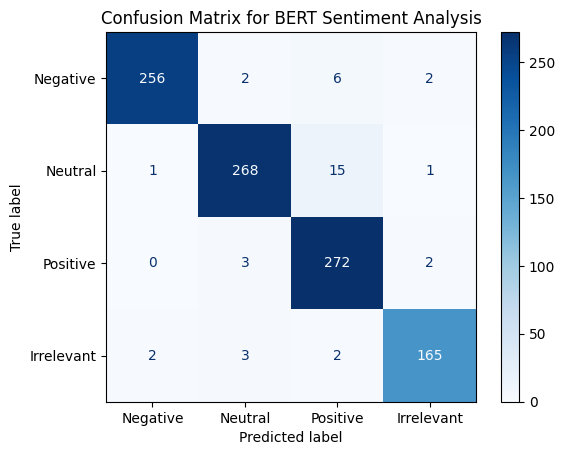

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define label names
labels = ['Negative', 'Neutral', 'Positive', 'Irrelevant']  # String labels corresponding to [0, 1, 2, 3]

# Calculate the confusion matrix
confusion_matrix_BERT = confusion_matrix(test_true, test_preds, labels=[0, 1, 2, 3])

print("BERT Confusion Matrix:\n", confusion_matrix_BERT)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_BERT, display_labels=labels)
disp.plot(cmap='Blues')
disp.ax_.set_title("Confusion Matrix for BERT Sentiment Analysis")
disp.ax_.grid(False)  # Turn off the grid for better visualization
